In [1]:
# from tile_match_gym.tile_match_env import TileMatchEnv
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from copy import deepcopy
from numba import njit
from tile_match_env import TileMatchEnv
from collections import defaultdict
# register(id="TileMatch-v0", entry_point="tile_match_gym.tile_match_env:TileMatchEnv")
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
# % matplotlib inline
from tile_match_gym.wrappers import ProportionRewardWrapper, OneHotWrapper
import distinctipy
from PIL import Image
from IPython.display import clear_output

import numba


In [3]:
def test_timing():
    import time
    env = TileMatchEnv(30, 30, 12, 10, [], [], seed=1)
    env = OneHotWrapper(env)
    start = time.time()
    # run for 1000 steps
    obs, info = env.reset()
    for _ in range(1000):
        action = env.action_space.sample()
        next_obs, _, done, _, _ = env.step(action)
        obs = next_obs
        if done:
            obs, info = env.reset()
    print(f"Time taken for 1000 steps: {time.time() - start} seconds")

In [4]:
import cProfile
profiler = cProfile.Profile()
profiler.run("test_timing()")
# test_timing()


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(undefined, 1d, C), int32, array(UniTuple(int32 x 2), 1d, C))
 
There are 16 candidate implementations:
   - Of which 16 did not match due to:
   Overload of function 'setitem': File: <numerous>: Line N/A.
     With argument(s): '(array(undefined, 1d, C), int32, array(UniTuple(int32 x 2), 1d, C))':
    No match.

During: typing of setitem at /home/akshil/research/tile-match-gym/src/tile_match_gym/board.py (102)

File "board.py", line 102:
    def __init__(
        <source elided>
        
        self.indices = np.array([[(r, c) for r in range(self.num_cols)] for c in range(self.num_rows)])
        ^

During: resolving callee type: jitclass.Board#7f45d1b77f40<num_rows:int32,num_cols:int32,num_colours:int32,flat_size:int32,colourless_specials:ListType[unicode_type],colour_specials:ListType[unicode_type],specials:ListType[unicode_type],np_random:NumPyRandomGeneratorType,board:OptionalType(array(int32, 3d, C)),indices:array(int32, 3d, C)>
During: typing of call at <string> (3)

During: resolving callee type: jitclass.Board#7f45d1b77f40<num_rows:int32,num_cols:int32,num_colours:int32,flat_size:int32,colourless_specials:ListType[unicode_type],colour_specials:ListType[unicode_type],specials:ListType[unicode_type],np_random:NumPyRandomGeneratorType,board:OptionalType(array(int32, 3d, C)),indices:array(int32, 3d, C)>
During: typing of call at <string> (3)


File "<string>", line 3:
<source missing, REPL/exec in use?>


In [ ]:
from numba import types, typed



In [4]:
profiler.print_stats(sort="cumtime")

         20642286 function calls (19694881 primitive calls) in 16.318 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     98/1    0.001    0.000   16.327   16.327 {built-in method builtins.exec}
        1    0.000    0.000   16.327   16.327 <string>:1(<module>)
        1    0.006    0.006   16.327   16.327 3033968959.py:1(test_timing)
      101    0.001    0.000   11.745    0.116 core.py:511(reset)
      101    0.001    0.000   11.735    0.116 tile_match_env.py:69(reset)
        2    0.000    0.000   11.163    5.581 dispatcher.py:388(_compile_for_args)
    262/2    0.004    0.000   11.153    5.576 dispatcher.py:907(compile)
     42/2    0.000    0.000   11.152    5.576 dispatcher.py:124(compile)
     42/2    0.000    0.000   11.152    5.576 dispatcher.py:131(_compile_cached)
     42/2    0.003    0.000   11.152    5.576 dispatcher.py:146(_compile_core)
     42/2    0.000    0.000   11.151    5.576 compiler.py:725(compile

In [13]:
from typing import Tuple
from numba import njit

@njit
def swap_coords(board: np.ndarray, coord1: Tuple[int, int], coord2: Tuple[int, int]) -> None: 
    board[0, coord1[0], coord1[1]], board[0, coord2[0], coord2[1]] = board[0, coord2[0], coord2[1]], board[0, coord1[0], coord1[1]]
    board[1, coord1[0], coord1[1]], board[1, coord2[0], coord2[1]] = board[1, coord2[0], coord2[1]], board[1, coord1[0], coord1[1]]


@njit
def is_move_effective(board: np.ndarray, coord1: Tuple[int, int], coord2: Tuple[int, int]) -> bool:
    """
    This function checks if the action actually does anything i.e. if the action achieves some form of matching.

    Args:
        coord (tuple): The first coordinate on grid corresponding to the action taken. This will always be above or to the left of the second coordinate below.
        coord2 (tuple): Second coordinate on grid corresponding to the action taken.

    Returns:
        bool: True iff action has an effect on the environment.
    """
    num_rows, num_cols = board.shape[1:]
    # Checks if both are special
    if (board[1, coord1[0], coord1[1]] not in [0, 1] ) and (board[1, coord2[0], coord2[1]] not in [0, 1]):
        return True

    # At least one colourless special.
    if board[1, coord1[0], coord1[1]] < 0 or board[1, coord2[0], coord2[1]] < 0:
        return True

    # Extract a minimal grid around the coords to check for at least 3 match. This covers checking for Ls or Ts.

    r_min = max(0, min(coord1[0], coord2[0]) - 2)
    r_max = min(num_rows-1, max(coord1[0], coord2[0]) + 2)
    c_min = max(0, min(coord1[1], coord2[1]) - 2)
    c_max = min(num_cols-1, max(coord1[1], coord2[1]) + 2)
    
    # print(f"for coords: {coord1}, {coord2}, row range: {r_min} - {r_max}, col range: {c_min} - {c_max}")
    
    # Swap the coordinates_ to see what happens.
    swap_coords(board, coord1, coord2)
    colour_slice = board[0, r_min:r_max + 1, c_min:c_max + 1]
    # Horizontal Matches
    if c_min + 2 <= c_max:
        # horizontal_slice = colour_slice  # Slice for horizontal comparison
        horizontal_matches = (colour_slice[:, :-2] == colour_slice[:, 1:-1]) & (colour_slice[:, 1:-1] == colour_slice[:, 2:])
        matching_indices = np.nonzero(horizontal_matches & (board[1, r_min:r_max + 1, c_min + 2:c_max + 1] > 0))
        if matching_indices[0].size > 0:
            # Swap back
            swap_coords(board, coord1, coord2)
            return True

    # Vertical Matches
    if r_min + 2 <= r_max:
        # vertical_slice = colour_slice  # Slice for vertical comparison
        vertical_matches = (colour_slice[:-2, :] == colour_slice[1:-1, :]) & (colour_slice[1:-1, :] == colour_slice[2:, :])
        matching_indices = np.nonzero(vertical_matches & (board[1, r_min + 2:r_max + 1, c_min:c_max + 1] > 0))
        if matching_indices[0].size > 0:
            # Swap back
            swap_coords(board, coord1, coord2)
            return True
        
    swap_coords(board, coord1, coord2)
    return False


In [14]:
env = TileMatchEnv(30, 30, 12, 10, [], [], seed=1)
env.reset()

(OrderedDict([('board',
               array([[[12, 11,  7, ...,  6,  7,  7],
                       [11, 11,  3, ..., 12,  2, 10],
                       [ 8,  7,  2, ..., 12,  9,  6],
                       ...,
                       [ 4, 11, 10, ...,  8,  6,  7],
                       [12,  1, 11, ...,  8, 11,  2],
                       [ 8,  2,  9, ...,  5,  9,  2]],
               
                      [[ 1,  1,  1, ...,  1,  1,  1],
                       [ 1,  1,  1, ...,  1,  1,  1],
                       [ 1,  1,  1, ...,  1,  1,  1],
                       ...,
                       [ 1,  1,  1, ...,  1,  1,  1],
                       [ 1,  1,  1, ...,  1,  1,  1],
                       [ 1,  1,  1, ...,  1,  1,  1]]], dtype=int32)),
              ('num_moves_left', 10)]),
 {'effective_actions': [13,
   34,
   49,
   118,
   125,
   132,
   183,
   246,
   247,
   251,
   266,
   305,
   333,
   363,
   372,
   375,
   408,
   413,
   427,
   437,
   443,
   470,
   5

In [15]:
board = env.board.board.copy()

In [17]:
env._action_to_coords(13)

((0, 13), (1, 13))

In [19]:
is_move_effective(board, (0, 13), (1, 13))

True

In [3]:
rng = numba.random.RandomState(0)
num_colours = 7

rng.integers(1, 7+1, 12).reshape(3, 4)

AttributeError: module 'numba' has no attribute 'random'

In [3]:
env.render()

 ---------
| 1 1 1 1 |
| 1 1 1 1 |
| 1 1 1 1 |
| 1 1 1 1 |
| 1 1 1 1 |
 ---------


c:\Users\ap2078\AppData\Local\miniconda3\envs\tile_match_gym\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


In [ ]:
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

In [ ]:
def run_episode(agent, env, obs_seen):
    obs, info = env.reset()
    done = False
    total_reward = 0
    num_effective_actions = 0
    
    obs_seen[agent._preprocess_obs(obs)] += 1
    while True:
        action = agent.choose_action(obs)
        next_obs, reward, done, _, info = env.step(action)
        obs_seen[agent._preprocess_obs(next_obs)] += 1
        agent.update(obs, action, reward, next_obs, done)
        num_effective_actions += int(reward > 0)
        total_reward += reward

        if done:
            break
        else:
            obs = next_obs
    return total_reward, num_effective_actions, obs_seen


def train(agent, num_episodes:int = 1000):
    env = gym.make("TileMatch", num_rows=3, num_cols=2, num_colours=2, num_moves=10, colour_specials=[], colourless_specials=[])
    env = ProportionRewardWrapper(env)
    epi_r = np.zeros(num_episodes)
    obs_seen = defaultdict(int)
    num_effective_actions_arr = np.zeros(num_episodes)
    num_shuffled = np.zeros(num_episodes)
    print_eps = True
    for i in tqdm(range(num_episodes)):
        total_reward, num_effective_actions, obs_seen = run_episode(agent, env, obs_seen)
        if agent.epsilon > 0.05:
            agent.epsilon *= 0.9999
        elif print_eps:
            print(f"Epsilon is low at episode {i}")
            print_eps = False
        epi_r[i] = total_reward
        num_effective_actions_arr[i] = num_effective_actions
    return epi_r, num_effective_actions_arr, obs_seen, agent

In [ ]:
class QLearningAgent:
    def __init__(self, lr, epsilon, gamma, num_actions, rng):
        self.lr = lr
        self.epsilon = epsilon
        self.gamma = gamma
        self.num_actions = num_actions
        self.q_table = defaultdict(lambda: np.zeros(self.num_actions, dtype=np.float32))
        self.rng = rng
        

    def choose_action(self, obs, effective_actions = None):
        s = self._preprocess_obs(obs)
        if self.rng.random() < self.epsilon:
            if effective_actions == None:
                return self.rng.choice(self.num_actions)
            else:
                return self.rng.choice(effective_actions)
        else:
            q_vals = self.q_table[s]
            if effective_actions != None:
                qs = q_vals[effective_actions]
                return effective_actions[self.rng.choice(np.flatnonzero(qs == qs.max()))]
            else:
                return self.rng.choice(np.flatnonzero(q_vals == q_vals.max()))
            
    def update(self, obs, action, reward, next_obs, done):
        s = self._preprocess_obs(obs)
        next_s = self._preprocess_obs(next_obs)
        q_vals = self.q_table[s]
        next_q_vals = self.q_table[next_s]
        q_target = reward + self.gamma * (1-done) * next_q_vals.max()
        self.q_table[s][action] += self.lr * ( q_target - q_vals[action])

    def _preprocess_obs(self, obs):
        board, num_moves = obs["board"], obs["num_moves_left"]
        o = board.flatten().tolist() + [num_moves]
        return tuple(o)
    
class RandomAgent:
    def __init__(self, num_actions, rng, use_effective_actions = False):
        self.num_actions = num_actions
        self.use_effective_actions = use_effective_actions
        self.rng = rng

    def choose_action(self, obs, *args, effective_actions=None, **kwargs):
        if self.use_effective_actions and effective_actions != None:
            return self.rng.choice(effective_actions)
        return self.rng.choice(range(self.num_actions))


def run_episode(agent, env, obs_seen):
    obs, info = env.reset()
    done = False
    total_reward = 0
    num_effective_actions = 0
    
    obs_seen[agent._preprocess_obs(obs)] += 1
    while True:
        action = agent.choose_action(obs)
        next_obs, reward, done, _, info = env.step(action)
        obs_seen[agent._preprocess_obs(next_obs)] += 1
        agent.update(obs, action, reward, next_obs, done)
        num_effective_actions += int(reward > 0)
        total_reward += reward
        if done:
            break
        else:
            obs = next_obs
    return total_reward, num_effective_actions, obs_seen


def train(agent, env, num_episodes:int = 1000):
    epi_r = np.zeros(num_episodes)
    obs_seen = defaultdict(int)
    num_effective_actions_arr = np.zeros(num_episodes)
    print_eps = True
    for i in tqdm(range(num_episodes)):
        total_reward, num_effective_actions, obs_seen = run_episode(agent, env, obs_seen)
        if agent.epsilon > 0.1:
            agent.epsilon *= 0.9999
        elif print_eps:
            print(f"Epsilon is low at episode {i}")
            print_eps = False
        epi_r[i] = total_reward
        num_effective_actions_arr[i] = num_effective_actions
    return epi_r, num_effective_actions_arr, obs_seen, agent

In [ ]:
rng = np.random.default_rng(0)
env = gym.make("TileMatch-v0", num_rows=3, num_cols=3, num_colours=2, num_moves=10, colour_specials=[], colourless_specials=[], seed=100)
env = ProportionRewardWrapper(env)
agent = QLearningAgent(lr=0.25, epsilon=1, gamma=0.7, num_actions=env.num_actions, rng=rng)
r, eff_a, obs_seen, agent = train(agent, env, 400_000)

c:\Users\ap2078\AppData\Local\miniconda3\envs\tile_match_gym\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_actions` for environment variables or `env.get_wrapper_attr('num_actions')` that will search the reminding wrappers.
  logger.warn(
  6%|▌         | 23047/400000 [01:21<26:52, 233.75it/s]

Epsilon is low at episode 23025


100%|██████████| 400000/400000 [29:38<00:00, 224.93it/s]


In [ ]:
old_r, old_eff_a, old_obs_seen = deepcopy(r), deepcopy(eff_a), deepcopy(obs_seen)

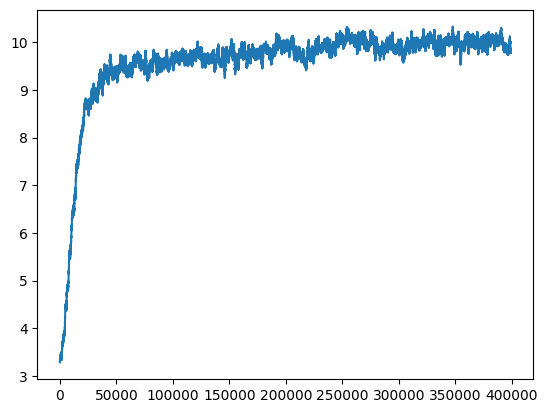

In [ ]:
plt.plot(moving_average(r, 800))

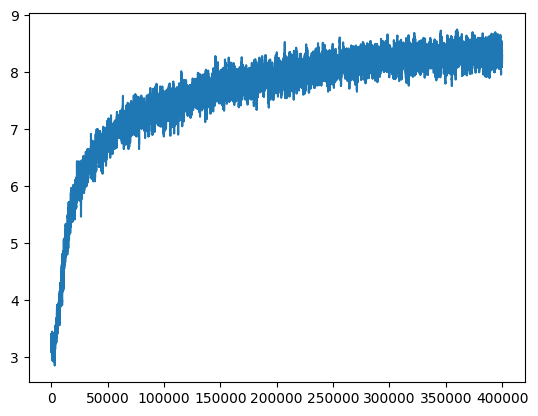

In [ ]:

plt.plot(moving_average(eff_a, 150))

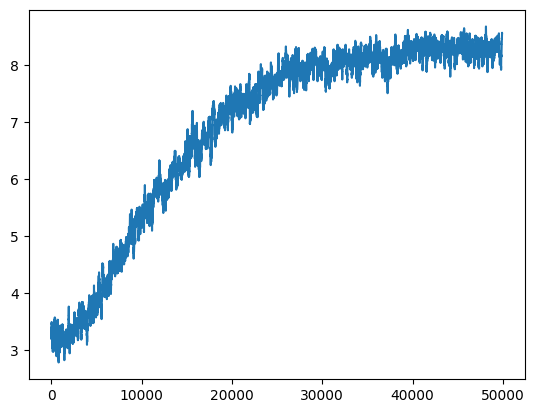

In [ ]:
plt.plot(moving_average(eff_a, 100))

In [ ]:
# Plot rolling averages.
# Run for longer to see if the agent explores enough.

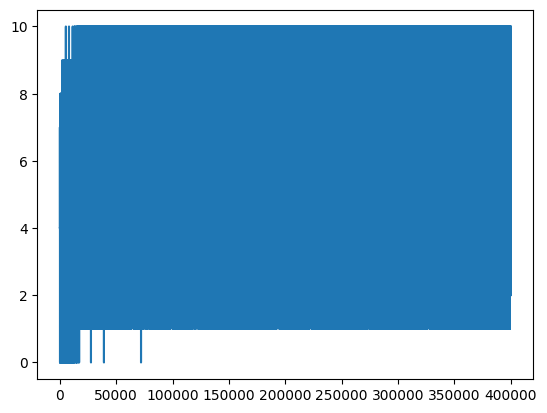

In [ ]:
plt.plot(eff_a)

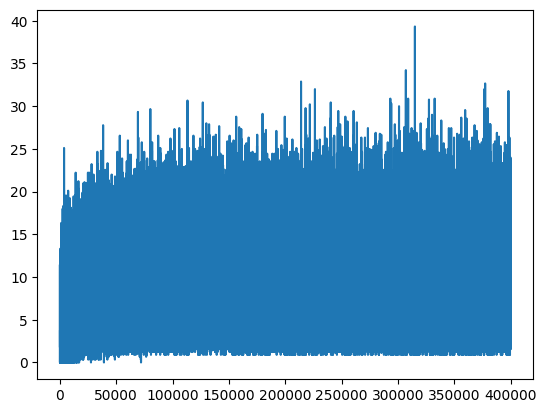

In [ ]:
plt.plot(r)

In [ ]:
obs_seen

defaultdict(int,
            {(2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10): 4203,
             (2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9): 3209,
             (1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 8): 342,
             (1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 7): 632,
             (1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 6): 293,
             (1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 5): 318,
             (1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4): 115,
             (1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3): 193,
             (1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 2): 139,
             (2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1): 213,
             (2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 0): 186,
             (1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10): 4316,
             (1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1

In [ ]:
o = sorted(obs_seen.items(), key = lambda x : x[1], reverse=False)


In [ ]:
o

[((2, 1, 1, 1, 2, 2, 2, 1, 2, 4, 4, 1, 1, 1, 1, 1, 1, 1, 2), 1),
 ((2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 7), 1),
 ((2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 4, 1, 4, 4, 1, 1, 1, 1), 1),
 ((2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 4, 4, 1, 1, 1, 1, 2), 1),
 ((1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 4, 4, 1, 1, 9), 1),
 ((1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 4, 4, 1, 1, 2), 1),
 ((2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 9), 1),
 ((1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 4, 1, 4, 1, 1, 4, 1, 2), 1),
 ((1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 4, 1, 4, 1, 1, 4, 1, 1), 1),
 ((1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 4, 1, 4, 1, 1, 4, 1, 0), 1),
 ((2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 4, 1, 4, 1, 1, 8), 1),
 ((2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 4, 4, 1, 1, 7), 1),
 ((2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 4, 4, 1, 1, 6), 1),
 ((2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 0), 1),
 ((2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 4, 1, 1, 4, 1, 1, 4, 5), 1),
 ((2, 1, 1, 1, 2, 2, 2, 1

In [ ]:
agent.epsilon

0.04996170339735633

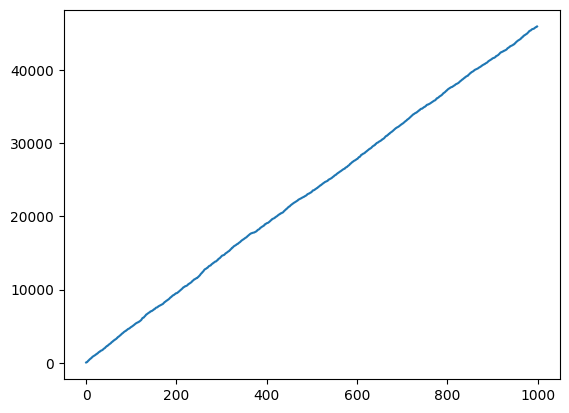

In [ ]:
plt.plot(np.cumsum(r))

In [ ]:
obs, info =  env.reset()
obs, info

(OrderedDict([('board',
               array([[[1, 2, 2],
                       [2, 1, 2],
                       [2, 1, 1]],
               
                      [[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]])),
              ('num_moves_left', 10)]),
 {'effective_actions': [0, 1, 6]})

In [ ]:
agent.q_table[agent._preprocess_obs(obs)]

array([0. , 2.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
      dtype=float32)

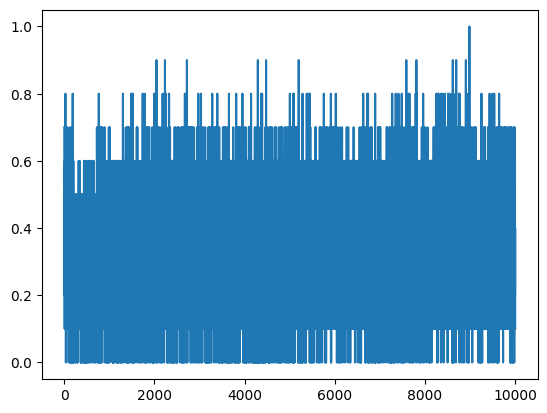

In [ ]:
plt.plot(eff_a / 10)

In [ ]:
env = TileMatchEnv(3, 3, 2, 5, [], [], 1)
env.reset()
env.board.board[0] = np.array([[1, 2, 2], [2, 1, 1], [2, 2, 1]])

effective_actions = env._get_effective_actions()
print(effective_actions)
assert effective_actions == [0, 6, 8]#

env = TileMatchEnv(3, 3, 2, 10, colour_specials=["vertical_laser", "horizontal_laser", "bomb"], colourless_specials=["cookie"])
env.reset()
env.board.board[0] = np.array([[1, 2, 2], [2, 1, 1], [2, 2, 1]])
assert effective_actions == [0, 6, 8]

[0, 6, 8]


In [ ]:
env.step(1)

(OrderedDict([('board',
               array([[[1, 2, 2],
                       [2, 1, 1],
                       [2, 2, 1]],
               
                      [[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]])),
              ('num_moves_left', 9)]),
 0,
 False,
 False,
 {'is_combination_match': False,
  'num_new_specials': 0,
  'num_specials_activated': 0,
  'shuffled': False,
  'effective_actions': [0, 6, 8]})

In [ ]:
env.step(4)

(OrderedDict([('board',
               array([[[1, 1, 2],
                       [1, 1, 2],
                       [2, 2, 1]],
               
                      [[1, 1, 1],
                       [1, 1, 1],
                       [4, 4, 1]]])),
              ('num_moves_left', 6)]),
 16,
 False,
 False,
 {'is_combination_match': False,
  'num_new_specials': 2,
  'num_specials_activated': 0,
  'shuffled': False,
  'effective_actions': [5, 10, 11]})